In [ ]:
import requests
import csv
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import rasterio
from rasterio.mask import mask
from rasterstats import zonal_stats
from rasterio import Affine
from rasterio.enums import Resampling
from esda.moran import Moran
import libpysal
import seaborn as sns
import matplotlib.pyplot as plt

# Collect Census Block Group Level Demographic Data

In [93]:
bg = gpd.read_file("../USGS_Raster/BlockGroup_shp/tl_2021_36_bg.shp")
bg = bg[bg['COUNTYFP'].isin(['005', '047', '061', '081', '085'])]
bg.rename(columns={'GEOID':'geoid'},inplace=True)
bg = bg[['geoid','geometry']]

data_url_base = "https://api.census.gov/data/2023/acs/acs5?get="
pop_variable = "B01001_001E,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B02001_006E,B02001_007E,B19013_001E"
edu_variable = 'B15003_001E,B15003_022E,B15003_023E,B15003_024E,B15003_025E'
other_variable = 'B25046_001E'
variable = pop_variable + "," + edu_variable + ',' + other_variable
data_url = data_url_base + variable
data_url = data_url + '&for=block%20group:*&in=state:36&in=county:*&in=tract:*' + "&key=YourKey"
print(data_url)
response = requests.get(data_url)
popdata = response.json()
df = pd.DataFrame(popdata)
df.columns = df.iloc[0]
df = df[1:]
    
df.rename(columns={'B01001_001E': 'Total Population',
                   'B02001_002E': 'White',
                   'B02001_003E': 'Black',
                   'B02001_004E': 'American Indian and Alaska Native',
                   'B02001_005E': 'Asian',
                   'B02001_006E': 'Native Hawaiian and Other Pacific Islander',
                   'B02001_007E': 'Some other',
                   'B15003_001E': 'Total Over 25',
                   'B15003_022E': 'Bachelor',
                   'B15003_023E': 'Master',
                   'B15003_024E': 'Professional',
                   'B15003_025E': 'Doctor',
                   'B19013_001E': 'Median Household Income', 
                   'B25046_001E': 'Total Vehicle',
                   }, inplace=True)
df['geoid'] = df['state'] + df['county'] + df['tract'] + df["block group"]
df['Over Bachelor'] = (df['Bachelor'].astype(int) + df['Master'].astype(int) + df['Professional'].astype(int) + df['Doctor'].astype(int))

df = df.drop(['state','county','tract', "block group",'Bachelor','Master','Professional','Doctor'], axis=1) 
bg = bg.merge(df, on='geoid',how='left')
# bg.head()
bg.to_file("../UHI_PCA/Demo_BlockGroup.geojson", driver="GeoJSON")

https://api.census.gov/data/2023/acs/acs5?get=B01001_001E,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B02001_006E,B02001_007E,B19013_001E,B15003_001E,B15003_022E,B15003_023E,B15003_024E,B15003_025E,B25046_001E&for=block%20group:*&in=state:36&in=county:*&in=tract:*&key=6787aadbdc0868ff9ba8e09b83cb3f4cf392b239


# Processing the Raster Data
1. Clip All the Raster Data to NYC Scale
2. Layer all the NYC Scale raster together to get the overall temperature data
3. Calculate Every Census Block Group's Temperature

In [5]:
nyc_boundary = gpd.read_file("../USGS_Raster/Borough.geojson")
with rasterio.open("../USGS_Raster/raw_raster/L2SP_20250416.TIF") as src:
    tif_crs = src.crs
nyc_boundary = nyc_boundary.to_crs(tif_crs)
nyc_geom = nyc_boundary.geometry.values

input_folder = "../../raw_raster"
output_folder = "../../nyc_raster"
os.makedirs(output_folder, exist_ok=True)

tif_files = sorted([f for f in os.listdir(input_folder) if f.endswith(".TIF")])


for tif_file in tif_files:
    input_path = os.path.join(input_folder, tif_file)
    output_path = os.path.join(output_folder, tif_file)

    with rasterio.open(input_path) as src:
        out_image, out_transform = mask(src, nyc_geom, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            "nodata": src.nodata
        })

        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)


In [6]:
folder = "../../nyc_raster"
tif_files = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".TIF")])
weights = np.ones(len(tif_files)) 
sum_array = None
profile = None

# Loop to merge the raster data together
for i, tif_path in enumerate(tif_files):
    with rasterio.open(tif_path) as src:
        arr = src.read(1).astype("float32") 
        mask = (arr != src.nodata) if src.nodata is not None else np.ones_like(arr, dtype=bool)

        if sum_array is None:
            sum_array = np.zeros_like(arr)
            count_array = np.zeros_like(arr)
            profile = src.profile
        arr[~mask] = 0  # If it's nodata, assign 0 to it
        sum_array += arr * weights[i]
        count_array += mask * weights[i]

# Calculate the average temperature
count_array[count_array == 0] = np.nan
avg_array = sum_array / count_array
profile.update(dtype='float32', count=1, nodata=np.nan)


with rasterio.open("../UHI_PCA/temperature_weighted.tif", "w", **profile) as dst:
    dst.write(avg_array.astype("float32"), 1)


In [96]:
bg_gdf = gpd.read_file("../UHI_PCA/Demo_BlockGroup.geojson")
boundary_gdf = gpd.read_file("../USGS_Raster/Borough.geojson")
bg_gdf = bg_gdf.to_crs(boundary_gdf.crs)
bg_gdf = gpd.clip(bg_gdf, boundary_gdf)
raster_path = "../UHI_PCA/temperature_weighted.tif"
with rasterio.open(raster_path) as src:
    raster_crs = src.crs

bg_gdf = bg_gdf.to_crs(raster_crs)
stats = zonal_stats(
    bg_gdf, 
    raster_path, 
    stats=["mean"], 
    nodata=np.nan
)

bg_gdf['temperature_DN'] = [item['mean'] for item in stats]
bg_gdf.dropna(subset=['temperature_DN'], inplace=True)
bg_gdf['temperature_K'] = bg_gdf['temperature_DN'] * 0.00341802 + 149
bg_gdf['temperature_F'] = (bg_gdf['temperature_K'] -273.15) * 9 / 5 + 32
# bg_gdf.head()
bg_gdf.to_file("../UHI_PCA/blockgroup_with_temperature.geojson", driver="GeoJSON")

# Visualize the Block Group Level Temperature Using Natural Break

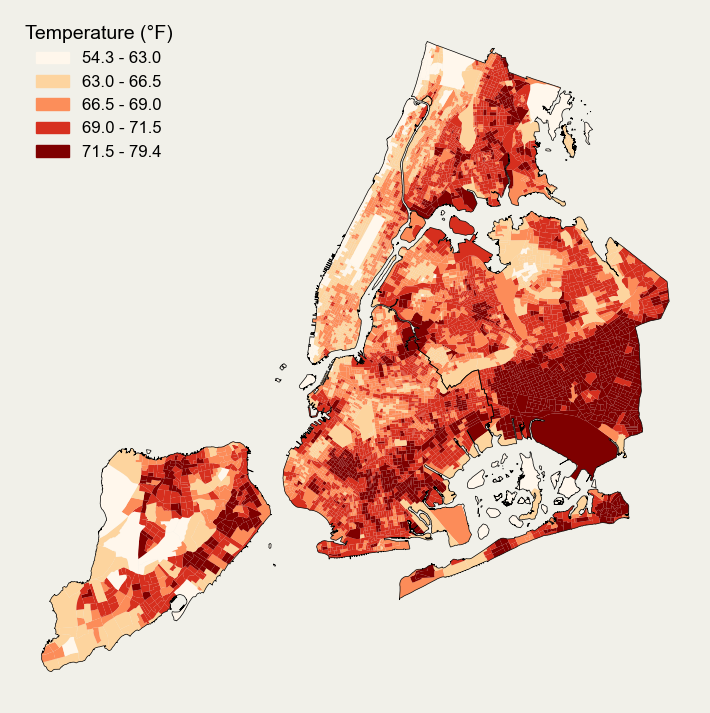

In [97]:
boundary_gdf = gpd.read_file("../USGS_Raster/Borough.geojson")
bg_gdf = gpd.read_file('../UHI_PCA/blockgroup_with_temperature.geojson')
boundary_gdf = boundary_gdf.to_crs(bg_gdf.crs)

# Using NaturalBreak to classify
classifier = mapclassify.NaturalBreaks(bg_gdf['temperature_F'], k=5)
bg_gdf['bin'] = classifier.yb
bin_edges = [bg_gdf['temperature_F'].min()] + list(classifier.bins)
# Legend's Label
labels = [f"{round(bin_edges[i], 1)} - {round(bin_edges[i+1], 1)}" for i in range(len(bin_edges)-1)]

# Setting Up the plt
plt.rcParams["font.family"] = "Arial"
fig, ax = plt.subplots(figsize=(9, 9))
fig.patch.set_facecolor("#F1F0E9")
ax.set_facecolor("#F1F0E9")

# Draw the pics
bg_gdf.plot(column='bin',cmap='OrRd',ax=ax,legend=False,edgecolor='none')
boundary_gdf.boundary.plot(ax=ax, color='black', linewidth=0.5)
ax.axis('off')

# Adding the Legend
cmap = plt.cm.OrRd
norm = colors.BoundaryNorm(boundaries=bin_edges, ncolors=cmap.N)
handles = [
    mpatches.Patch(color=cmap(norm((bin_edges[i] + bin_edges[i+1]) / 2)), label=labels[i]) 
    for i in range(len(labels))]
ax.legend(handles=handles,title="Temperature (°F)",loc='upper left',title_fontsize=14,fontsize=12,frameon=False)

# Save the pics
pics_path = '../UHI_PCA/NaturalBreak_BG.png'
fig.savefig(pics_path, dpi=300, facecolor='#F1F0E9')
plt.show()

# Adding tha MapPluto Data

In [6]:
# bg_gdf has the demographic data and temperature data
bg_gdf = gpd.read_file('../UHI_PCA/blockgroup_with_temperature.geojson')
bg_gdf.head()

,geoid,Total Population,White,Black,American Indian and Alaska Native,Asian,Native Hawaiian and Other Pacific Islander,Some other,Median Household Income,Total Over 25,Total Vehicle,Over Bachelor,temperature_DN,temperature_K,temperature_F,geometry
0,360850244022,2087,1899,0,0,0,0,14,94643,1509,None,497,41432.127273,290.615840,63.438511,"POLYGON ((563215.34 4483779.649, 563249.287 44..."
1,360850244021,2822,2507,3,0,98,0,27,128080,1894,1571,957,41420.911765,290.577505,63.369509,"POLYGON ((564331.064 4484088.008, 564350.929 4..."
2,360850244011,2020,2020,0,0,0,0,0,171496,1263,1357,700,42082.986577,292.840490,67.442882,"POLYGON ((563098.591 4484379.779, 563128.106 4..."
3,360850198000,0,0,0,0,0,0,0,-666666666,0,-666666666,0,40957.437500,288.993341,60.518013,"MULTIPOLYGON (((566635.704 4484268.392, 566635..."
4,360850244012,2011,1562,0,0,446,0,0,103000,1436,1422,382,42164.589474,293.119410,67.944938,"POLYGON ((564071.463 4484638.496, 564088.594 4..."


In [7]:
pluto = gpd.read_file('../UHI_PCA/nyc_mappluto_24v3_1_shp/MapPLUTO.shp')
pluto = pluto.astype({'BoroCode': str, 'Block': str, 'Lot': str})
pluto['Block'] = pluto['Block'].astype(str).str.zfill(5)
pluto['Lot'] = pluto['Lot'].astype(str).str.zfill(4)
pluto['mpluto_bbl'] = pluto['BoroCode'] + pluto['Block'] + pluto['Lot']
pluto.head()

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,PFIRM15_FL,Version,DCPEdited,Latitude,Longitude,Notes,Shape_Leng,Shape_Area,geometry,mpluto_bbl
0,MN,00002,0023,101,1000900,10009001022,9,1025,02,1,...,1,24v3.1,t,40.701171,-74.009243,None,0.0,96902.396190,"MULTIPOLYGON (((981181.714 194852.82, 981207.9...",1000020023
1,MN,00003,0003,101,1000900,10009001019,9,1020,02,1,...,1,24v3.1,t,40.701953,-74.013146,None,0.0,52985.951251,"POLYGON ((980713.169 194965.339, 980721.442 19...",1000030003
2,MN,00005,0010,101,1000900,10009001014,9,1017,02,1,...,1,24v3.1,None,40.702776,-74.010722,None,0.0,59912.940582,"POLYGON ((981444.514 195254.036, 981143.712 19...",1000050010
3,MN,00005,7501,101,1000900,10009001014,9,1017,02,1,...,1,24v3.1,None,40.702266,-74.010607,None,0.0,55990.211198,"POLYGON ((981480.323 195094.261, 981420.026 19...",1000057501
4,MN,00006,0001,101,1000900,10009001014,9,1017,02,1,...,1,24v3.1,t,40.702609,-74.009900,None,0.0,36256.558127,"POLYGON ((981642.486 195187.693, 981491.551 19...",1000060001


In [8]:
footprint = gpd.read_file('../UHI_PCA/Building Footprints_20250501.geojson')
footprint = footprint.to_crs(pluto.crs)
footprint['shape_area'] = footprint.geometry.area
footprint = footprint.rename(columns={'shape_area': 'built_area'})[['mpluto_bbl', 'built_area', 'heightroof']]
pluto = pluto.merge(footprint, on = 'mpluto_bbl', how='left')
# footprint.head()
pluto.head()

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,DCPEdited,Latitude,Longitude,Notes,Shape_Leng,Shape_Area,geometry,mpluto_bbl,built_area,heightroof
0,MN,00002,0023,101,1000900,10009001022,9,1025,02,1,...,t,40.701171,-74.009243,None,0.0,96902.396190,"MULTIPOLYGON (((981181.714 194852.82, 981207.9...",1000020023,5146.697599,37.0
1,MN,00003,0003,101,1000900,10009001019,9,1020,02,1,...,t,40.701953,-74.013146,None,0.0,52985.951251,"POLYGON ((980713.169 194965.339, 980721.442 19...",1000030003,401.613729,19.1144664
2,MN,00003,0003,101,1000900,10009001019,9,1020,02,1,...,t,40.701953,-74.013146,None,0.0,52985.951251,"POLYGON ((980713.169 194965.339, 980721.442 19...",1000030003,913.487234,13.0
3,MN,00005,0010,101,1000900,10009001014,9,1017,02,1,...,None,40.702776,-74.010722,None,0.0,59912.940582,"POLYGON ((981444.514 195254.036, 981143.712 19...",1000050010,40635.169961,303.14
4,MN,00005,7501,101,1000900,10009001014,9,1017,02,1,...,None,40.702266,-74.010607,None,0.0,55990.211198,"POLYGON ((981480.323 195094.261, 981420.026 19...",1000057501,30467.507803,511.0


In [13]:
bg_gdf = bg_gdf.to_crs(pluto.crs) #Pluoto CRS: 2263
pluto_bg = gpd.sjoin(pluto, bg_gdf[['geoid', 'geometry']], how='inner', predicate='intersects')

# -- Building Density & Lot Coverage Ratio
pluto_bg['Building_Area'] = pluto_bg['BuiltFAR'].fillna(0) * pluto_bg['LotArea'].fillna(0)
building_density = (pluto_bg.groupby('geoid').agg(Total_Building_Area=('Building_Area', 'sum'),
                                                  Total_Lot_Area=('LotArea', 'sum'), 
                                                  Total_Ground_Area=('built_area', 'sum')))
building_density['Building_Density'] = building_density['Total_Building_Area'] / building_density['Total_Lot_Area']
building_density['LotCoverageRatio'] = building_density['Total_Ground_Area'] / building_density['Total_Lot_Area']

# -- YearBuilt
pluto_bg['YearBuilt'] = pd.to_numeric(pluto_bg['YearBuilt'], errors='coerce')
pluto_bg = pluto_bg[(pluto_bg['YearBuilt'] > 1800) & (pluto_bg['YearBuilt'] <= 2025)]
building_age = (pluto_bg.groupby('geoid').agg(Avg_YearBuilt=('YearBuilt', 'mean')))
building_age = building_age.round().astype(int)

# -- LandUse
landuse = (pluto_bg.groupby(['geoid', 'LandUse']).agg(total_area=('LotArea', 'sum')).reset_index())
landuse = landuse.loc[landuse.groupby('geoid')['total_area'].idxmax()]
landuse = landuse[['geoid', 'LandUse']]
conditions = [
    landuse['LandUse'].isin(['01', '02', '03', '04']),
    landuse['LandUse'] == '05',
    landuse['LandUse'] == '06',
    landuse['LandUse'].astype(int) >= 7
]
choices = ['Residential', 'Commercial', 'Industrial', 'Facility']
landuse['LandUse_Category'] = np.select(conditions, choices, default='Other')
landuse_encoded = pd.get_dummies(landuse, columns=['LandUse_Category'])
landuse_encoded = landuse_encoded.drop('LandUse',axis = 1)

# -- BuildingVolume, Avg_NumFloor
pluto_bg['BuildingVolume'] = pluto_bg['built_area'] * pluto_bg['NumFloors'].fillna(0)
structure_stats = pluto_bg.groupby('geoid').agg(Avg_NumFloors=('NumFloors', 'mean'), 
                                                Total_BuildingVolume=('BuildingVolume', 'sum')).reset_index()

result = bg_gdf[['geoid', 'geometry']]
result = result.merge(building_density[['Building_Density', 'LotCoverageRatio']], on='geoid', how='left')
result = result.merge(building_age, on='geoid', how='left')
result = result.merge(landuse_encoded, on='geoid', how='left')
result = result.merge(structure_stats, on='geoid', how='left')
result.head()

,geoid,geometry,Building_Density,LotCoverageRatio,Avg_YearBuilt,LandUse_Category_Commercial,LandUse_Category_Facility,LandUse_Category_Industrial,LandUse_Category_Residential,Avg_NumFloors,Total_BuildingVolume
0,360850244022,"POLYGON ((913631.127 122388.128, 913743.054 12...",0.134363,0.075503,1985.0,False,True,False,False,1.982504,1.667367e+06
1,360850244021,"POLYGON ((917304.211 123358.518, 917369.611 12...",0.187071,0.029898,1986.0,False,True,False,False,1.977800,1.724815e+06
2,360850244011,"POLYGON ((913270.338 124361.993, 913367.075 12...",0.147544,0.090128,1970.0,False,True,False,False,1.875499,1.804110e+06
3,360850198000,"MULTIPOLYGON (((924874.292 123864.609, 924874....",0.000000,0.000290,1945.0,False,True,False,False,1.875000,1.739296e+04
4,360850244012,"POLYGON ((916472.762 125174.787, 916529.282 12...",0.325929,0.173037,1968.0,False,False,False,True,2.005575,2.139006e+06


In [17]:
bg_result = bg_gdf.merge(result, on=['geoid','geometry'], how='left')
bg_result.to_file("../UHI_PCA/bg_result.geojson", driver="GeoJSON")

In [18]:
bg_result.head()

,geoid,Total Population,White,Black,American Indian and Alaska Native,Asian,Native Hawaiian and Other Pacific Islander,Some other,Median Household Income,Total Over 25,...,geometry,Building_Density,LotCoverageRatio,Avg_YearBuilt,LandUse_Category_Commercial,LandUse_Category_Facility,LandUse_Category_Industrial,LandUse_Category_Residential,Avg_NumFloors,Total_BuildingVolume
0,360850244022,2087,1899,0,0,0,0,14,94643,1509,...,"POLYGON ((913631.127 122388.128, 913743.054 12...",0.134363,0.075503,1985.0,False,True,False,False,1.982504,1.667367e+06
1,360850244021,2822,2507,3,0,98,0,27,128080,1894,...,"POLYGON ((917304.211 123358.518, 917369.611 12...",0.187071,0.029898,1986.0,False,True,False,False,1.977800,1.724815e+06
2,360850244011,2020,2020,0,0,0,0,0,171496,1263,...,"POLYGON ((913270.338 124361.993, 913367.075 12...",0.147544,0.090128,1970.0,False,True,False,False,1.875499,1.804110e+06
3,360850198000,0,0,0,0,0,0,0,-666666666,0,...,"MULTIPOLYGON (((924874.292 123864.609, 924874....",0.000000,0.000290,1945.0,False,True,False,False,1.875000,1.739296e+04
4,360850244012,2011,1562,0,0,446,0,0,103000,1436,...,"POLYGON ((916472.762 125174.787, 916529.282 12...",0.325929,0.173037,1968.0,False,False,False,True,2.005575,2.139006e+06


# Adding Park Data

In [21]:
parks_gdf = gpd.read_file('../UHI_PCA/Parks_Properties/geo_export_f0123beb-83e1-4979-a160-48d7bbcc4bbf.shp')
parks_gdf = parks_gdf.to_crs(bg_result.crs)
bg_gdf = gpd.read_file('../UHI_PCA/bg_result.geojson')
bg_gdf['blockgroup_area'] = bg_gdf.geometry.area

intersect_gdf = gpd.overlay(bg_gdf, parks_gdf, how='intersection')
intersect_gdf['intersect_area'] = intersect_gdf.geometry.area
park_area_by_bg = intersect_gdf.groupby('geoid')['intersect_area'].sum().reset_index()
bg_gdf = bg_gdf.merge(park_area_by_bg, on='geoid', how='left')
bg_gdf['intersect_area'] = bg_gdf['intersect_area'].fillna(0)
bg_gdf['park_area_ratio'] = bg_gdf['intersect_area'] / bg_gdf['blockgroup_area']

bg_gdf.head()

,geoid,Total Population,White,Black,American Indian and Alaska Native,Asian,Native Hawaiian and Other Pacific Islander,Some other,Median Household Income,Total Over 25,...,LandUse_Category_Commercial,LandUse_Category_Facility,LandUse_Category_Industrial,LandUse_Category_Residential,Avg_NumFloors,Total_BuildingVolume,geometry,blockgroup_area,intersect_area,park_area_ratio
0,360850244022,2087,1899,0,0,0,0,14,94643,1509,...,False,True,False,False,1.982504,1.667367e+06,"POLYGON ((913631.127 122388.128, 913743.054 12...",8.575330e+06,4.216963e+06,0.491755
1,360850244021,2822,2507,3,0,98,0,27,128080,1894,...,False,True,False,False,1.977800,1.724815e+06,"POLYGON ((917304.211 123358.518, 917369.611 12...",1.056343e+07,2.168771e+06,0.205309
2,360850244011,2020,2020,0,0,0,0,0,171496,1263,...,False,True,False,False,1.875499,1.804110e+06,"POLYGON ((913270.338 124361.993, 913367.075 12...",5.718995e+06,7.668752e+05,0.134093
3,360850198000,0,0,0,0,0,0,0,-666666666,0,...,False,True,False,False,1.875000,1.739296e+04,"MULTIPOLYGON (((924874.292 123864.609, 924874....",3.766256e+04,2.007834e+04,0.533111
4,360850244012,2011,1562,0,0,446,0,0,103000,1436,...,False,False,False,True,2.005575,2.139006e+06,"POLYGON ((916472.762 125174.787, 916529.282 12...",5.513954e+06,0.000000e+00,0.000000


In [33]:
bg_gdf.insert(2, 'Population_Density', bg_gdf['Total Population'].astype(float) / bg_gdf['blockgroup_area'])
bg_gdf.insert(11, 'Vehicle_Density', bg_gdf['Total Vehicle'].astype(float) / bg_gdf['blockgroup_area'])
bg_gdf.head()

,geoid,Total Population,Population_Density,White,Black,American Indian and Alaska Native,Asian,Native Hawaiian and Other Pacific Islander,Some other,Median Household Income,...,LandUse_Category_Commercial,LandUse_Category_Facility,LandUse_Category_Industrial,LandUse_Category_Residential,Avg_NumFloors,Total_BuildingVolume,geometry,blockgroup_area,intersect_area,park_area_ratio
0,360850244022,2087,0.000243,1899,0,0,0,0,14,94643,...,False,True,False,False,1.982504,1.667367e+06,"POLYGON ((913631.127 122388.128, 913743.054 12...",8.575330e+06,4.216963e+06,0.491755
1,360850244021,2822,0.000267,2507,3,0,98,0,27,128080,...,False,True,False,False,1.977800,1.724815e+06,"POLYGON ((917304.211 123358.518, 917369.611 12...",1.056343e+07,2.168771e+06,0.205309
2,360850244011,2020,0.000353,2020,0,0,0,0,0,171496,...,False,True,False,False,1.875499,1.804110e+06,"POLYGON ((913270.338 124361.993, 913367.075 12...",5.718995e+06,7.668752e+05,0.134093
3,360850198000,0,0.000000,0,0,0,0,0,0,-666666666,...,False,True,False,False,1.875000,1.739296e+04,"MULTIPOLYGON (((924874.292 123864.609, 924874....",3.766256e+04,2.007834e+04,0.533111
4,360850244012,2011,0.000365,1562,0,0,446,0,0,103000,...,False,False,False,True,2.005575,2.139006e+06,"POLYGON ((916472.762 125174.787, 916529.282 12...",5.513954e+06,0.000000e+00,0.000000


# Adding Impervious Data

In [61]:
mn_gdb_path = "../UHI_PCA/Imprevious Area/Manhattan.gdb"
bk_gdb_path = "../UHI_PCA/Imprevious Area/Brooklyn.gdb"
br_gdb_path = "../UHI_PCA/Imprevious Area/Bronx.gdb"
qn_gdb_path = "../UHI_PCA/Imprevious Area/Queens.gdb"
si_gdb_path = "../UHI_PCA/Imprevious Area/Staten_Island.gdb"

gdf1 = gpd.read_file(mn_gdb_path, layer="MN_pIApp")
gdf2 = gpd.read_file(bk_gdb_path, layer="BK_pIApp")
gdf3 = gpd.read_file(br_gdb_path, layer="BX_pIApp")
gdf4 = gpd.read_file(qn_gdb_path, layer="QN_pIApp")
gdf5 = gpd.read_file(si_gdb_path, layer="SI_pIApp")
gdf5.rename(columns={'Pct_Impv': 'Percent_Impv'}, inplace=True)

gdf_merged = pd.concat([gdf1, gdf2, gdf3, gdf4, gdf5], ignore_index=True)
gdf_merged.head()

/opt/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:196: RuntimeWarning: organizePolygons() received an unexpected geometry.  Either a polygon with interior rings, or a polygon with less than 4 points, or a non-Polygon geometry.  Return arguments as a collection.
  return ogr_read(
/opt/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:196: RuntimeWarning: organizePolygons() received an unexpected geometry.  Either a polygon with interior rings, or a polygon with less than 4 points, or a non-Polygon geometry.  Return arguments as a collection.
  return ogr_read(


,BBL,Borough,Block,Lot,CD,Percent_Impv,create_name,create_date,edit_name,edit_date,SHAPE_Length,SHAPE_Area,geometry,Shape_Length,Shape_Area
0,1.000010e+09,MN,1,10,101.0,47.32,Arup,2020-03-12 19:41:19+00:00,None,NaT,12253.477166,9.041157e+06,"MULTIPOLYGON (((981191.798 190877.393, 981020....",NaN,NaN
1,1.000010e+09,MN,1,101,101.0,60.51,Arup,2020-03-12 19:41:19+00:00,None,NaT,4255.976053,5.237211e+05,"MULTIPOLYGON (((972409.69 190685.56, 972447.31...",NaN,NaN
2,1.000010e+09,MN,1,201,101.0,63.64,Arup,2020-03-12 19:41:19+00:00,None,NaT,5811.914665,2.016059e+06,"MULTIPOLYGON (((973839.736 193894.244, 972500....",NaN,NaN
3,1.000020e+09,MN,2,1,101.0,99.95,Arup,2020-03-12 19:41:19+00:00,None,NaT,1872.106859,2.092844e+05,"MULTIPOLYGON (((980948.418 194202.587, 980872....",NaN,NaN
4,1.000020e+09,MN,2,2,101.0,97.82,Arup,2020-03-12 19:41:19+00:00,None,NaT,1816.415868,1.914122e+05,"MULTIPOLYGON (((980948.418 194202.587, 980795....",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857530,5.066900e+09,SI,6690,120,503.0,0.00,Arup,2020-04-09 17:32:38+00:00,None,NaT,1542.550359,1.288234e+05,"MULTIPOLYGON (((927845.283 125687.633, 927894....",NaN,NaN
857531,5.066900e+09,SI,6690,140,503.0,0.00,Arup,2020-04-09 17:32:38+00:00,None,NaT,3599.030462,5.321865e+05,"MULTIPOLYGON (((927310.369 125709.246, 927399....",NaN,NaN
857532,5.077220e+09,SI,7722,100,503.0,0.00,Arup,2020-04-09 17:32:38+00:00,None,NaT,2911.274757,1.044964e+05,"MULTIPOLYGON (((921047.454 120667.282, 920979....",NaN,NaN
857533,5.077220e+09,SI,7722,150,503.0,0.00,Arup,2020-04-09 17:32:38+00:00,None,NaT,3014.593092,1.261341e+05,"MULTIPOLYGON (((920967.612 120620.434, 920887....",NaN,NaN


In [ ]:
gdf_merged['SHAPE_Area'] = gdf_merged.geometry.area
gdf_merged['Imprevious_Area'] = gdf_merged['Percent_Impv'] * gdf_merged['SHAPE_Area'] / 100
imp_gdf = gpd.sjoin(gdf_merged, bg_gdf[['geoid', 'geometry']], how='inner', predicate='intersects')
imprevious = (imp_gdf.groupby('geoid').agg(Total_Imprevious_Area=('Imprevious_Area', 'sum'),
                                           Total_Lot_Area=('SHAPE_Area', 'sum')))
imprevious['Impervious_Percent'] = imprevious['Total_Imprevious_Area'] / imprevious['Total_Lot_Area']
bg_gdf = bg_gdf.merge(imprevious['Impervious_Percent'], on='geoid', how='left')
bg_gdf.head()         

In [104]:
bg_gdf.to_file("../UHI_PCA/bg_result.geojson", driver="GeoJSON")

# GWR Analysis

In [153]:
# Moran's I
gdf = bg_gdf.copy()
w = libpysal.weights.Queen.from_dataframe(gdf)
w.transform = 'r'
moran = Moran(gdf["temperature_F"], w)
print(f"Moran’s I: {moran.I:.4f}, p-value: {moran.p_sim:.4f}")

/var/folders/by/nffhrfxd6n793x71v4vsffhc0000gn/T/ipykernel_16047/4053946263.py:8: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(gdf)


('WARNING: ', 45, ' is an island (no neighbors)')
('WARNING: ', 3189, ' is an island (no neighbors)')
Moran’s I: 0.7512, p-value: 0.0010


/opt/anaconda3/lib/python3.11/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 2 islands with ids: 45, 3189.
  W.__init__(self, neighbors, ids=ids, **kw)


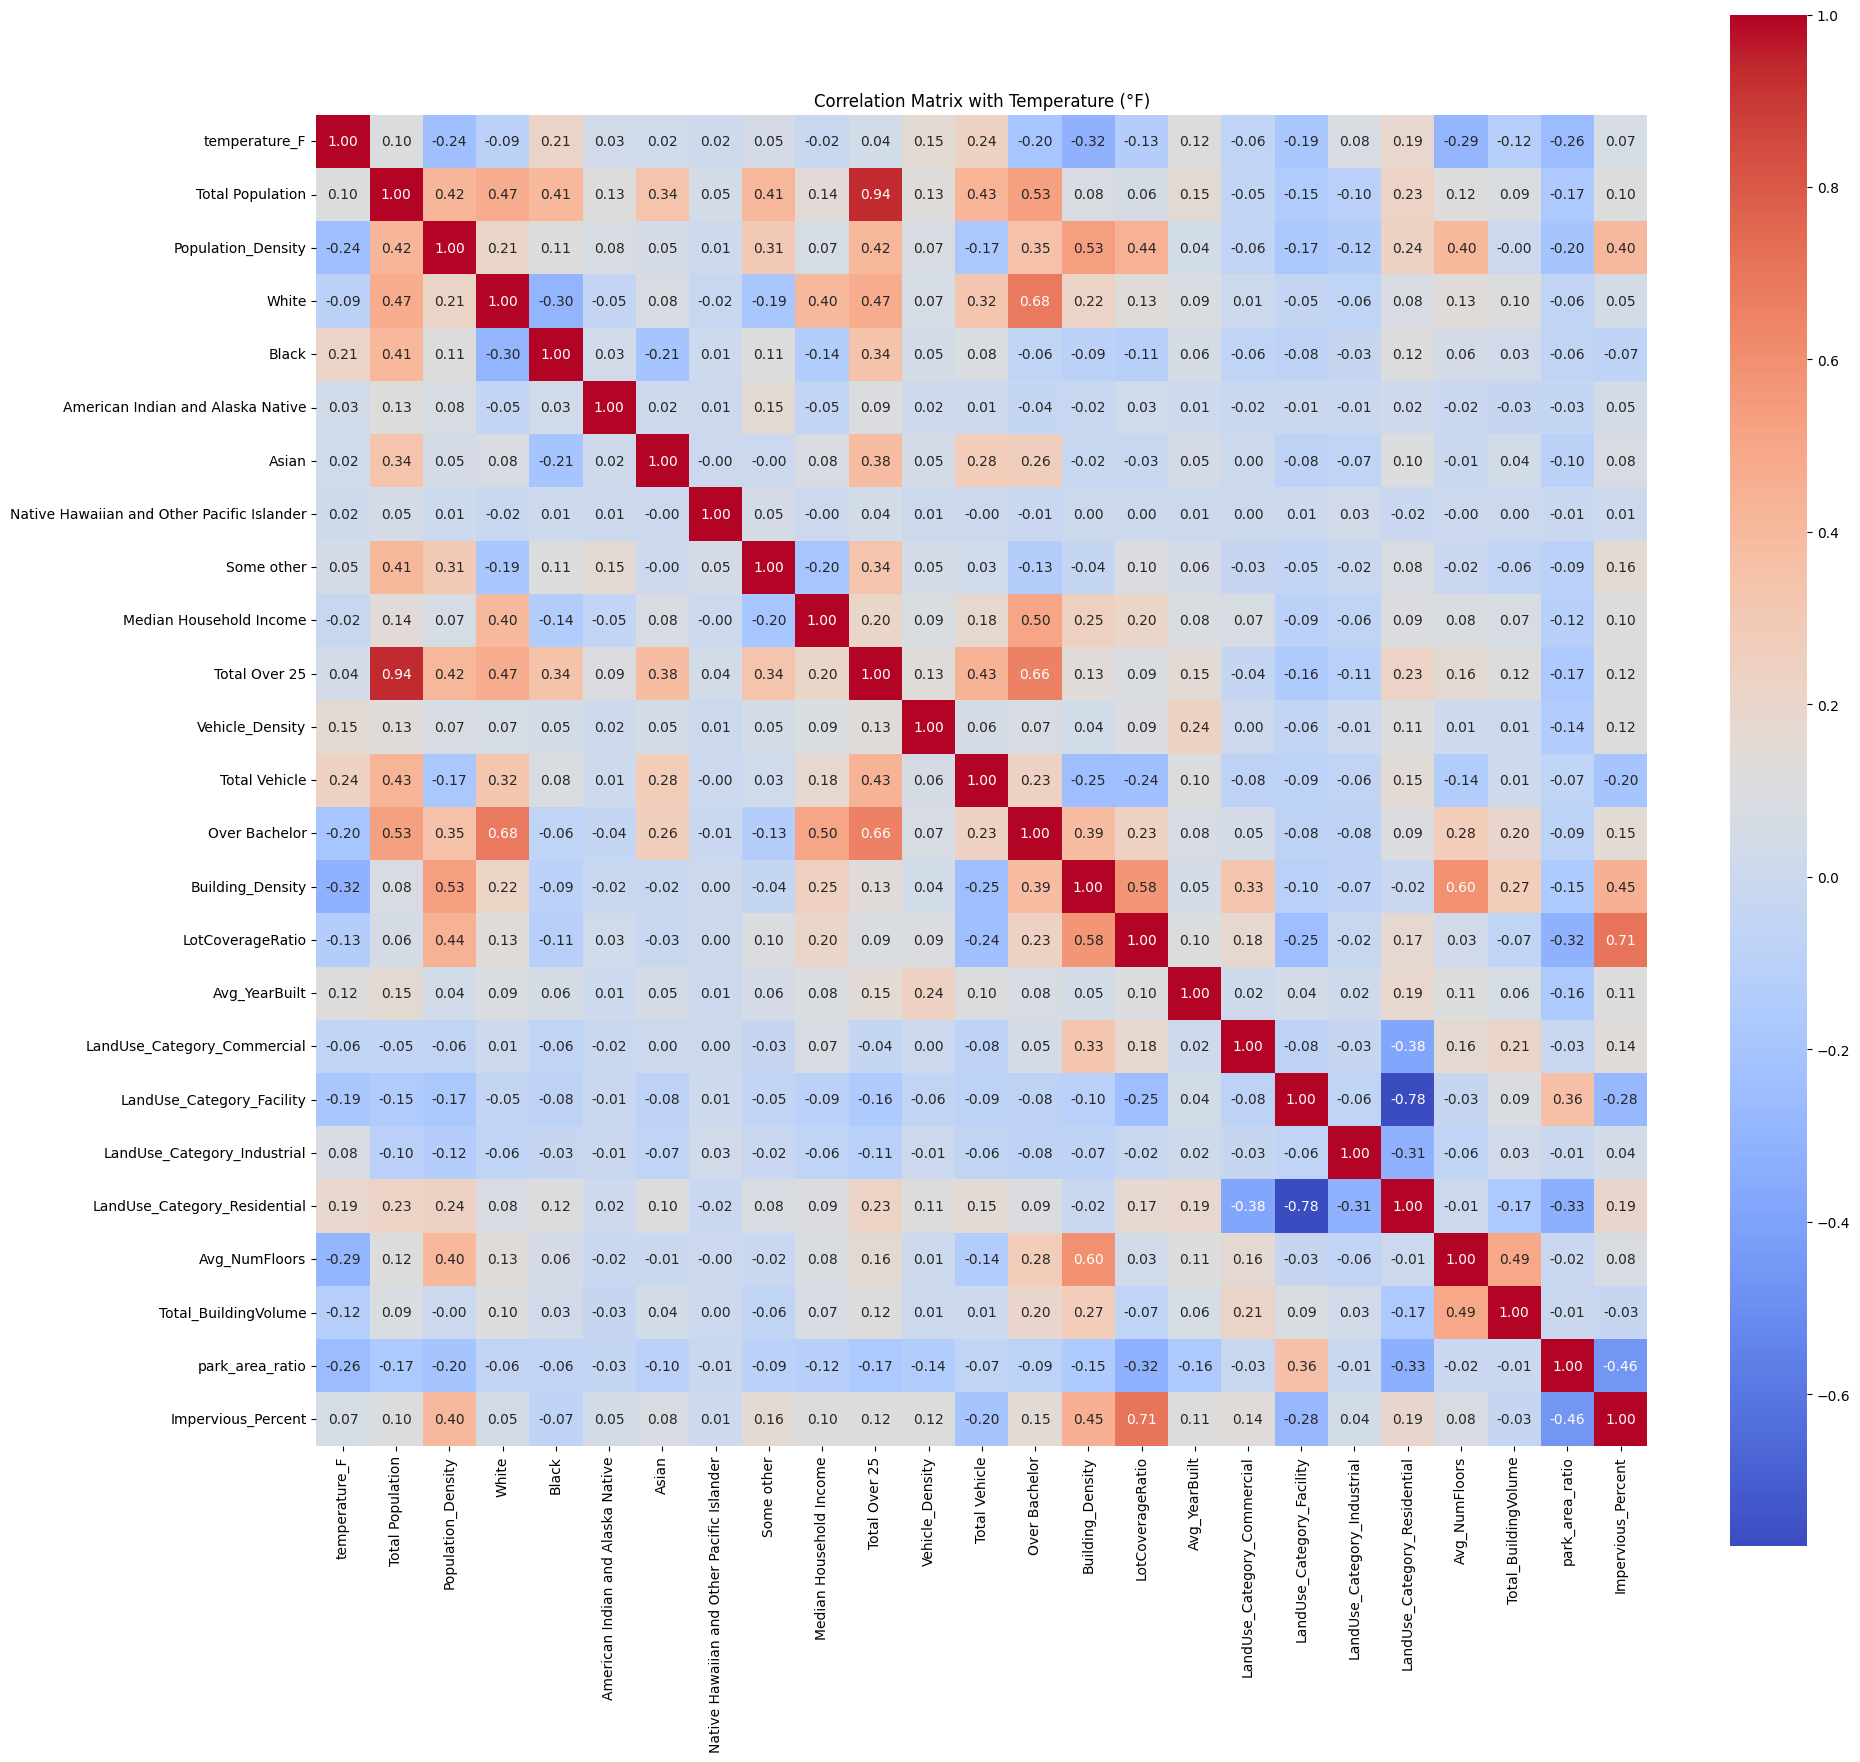

In [154]:
# Correlation Matrix
numeric_cols = ['temperature_F','Total Population', 'Population_Density', 'White', 'Black',
                'American Indian and Alaska Native', 'Asian',
                'Native Hawaiian and Other Pacific Islander', 'Some other',
                'Median Household Income', 'Total Over 25', 'Vehicle_Density',
                'Total Vehicle', 'Over Bachelor', 'Building_Density', 'LotCoverageRatio',
                'Avg_YearBuilt', 'LandUse_Category_Commercial',
                'LandUse_Category_Facility', 'LandUse_Category_Industrial',
                'LandUse_Category_Residential', 'Avg_NumFloors', 'Total_BuildingVolume',
                'park_area_ratio', 'Impervious_Percent']

gdf.loc[gdf['Total Population'] == 0, 'Population_Density'] = 0
gdf.loc[gdf['Total Vehicle'] == 0, 'Vehicle_Density'] = 0

for col in numeric_cols:
    if gdf[col].dtype == object:
        gdf[col] = gdf[col].replace({'True': True, 'False': False})
for col in numeric_cols:
    if gdf[col].dtype == bool:
        gdf[col] = gdf[col].astype(int)

gdf = gdf.fillna(0)

df_clean = gdf[numeric_cols].replace(['None', '-666666666', pd.NA], 0)
df_clean = df_clean.astype(float)

correlation_matrix = df_clean.corr()
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix with Temperature (\u00b0F)")
pics_path = '../UHI_PCA/corr_pic.png'
plt.savefig(pics_path, dpi=300, facecolor='#F1F0E9')
plt.tight_layout()
plt.show()

(0.0, 1.0500000000000005)

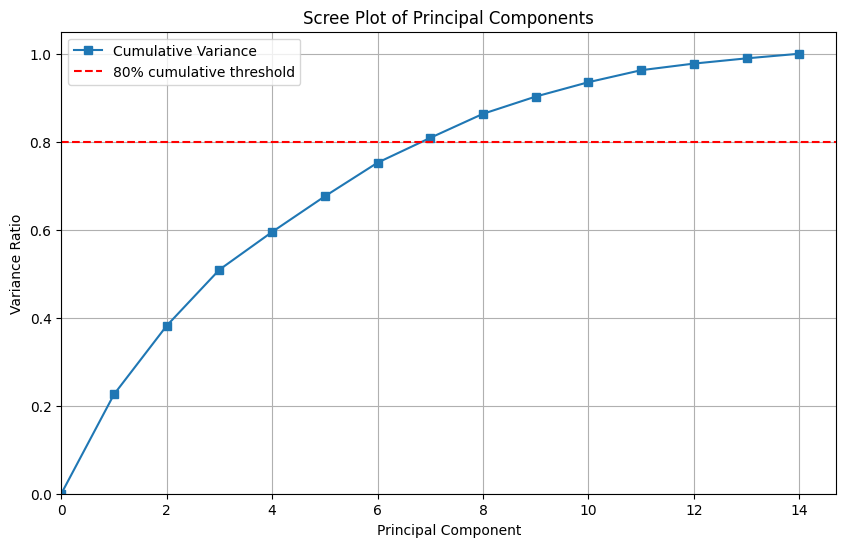

In [181]:
# Principle Component Analysis
feature_cols = ['Total Population', "Population_Density", "Black", 'Vehicle_Density', 'Total Vehicle',
                'Over Bachelor', 'Building_Density', 'LotCoverageRatio', 'Avg_YearBuilt',
                'LandUse_Category_Facility', 'LandUse_Category_Residential','Avg_NumFloors',
                'Total_BuildingVolume','park_area_ratio']
X = df_clean[feature_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
cumulative_variance = np.insert(cumulative_variance, 0, 0)

plt.figure(figsize=(10, 6))
plt.plot(range(0, len(cumulative_variance)), cumulative_variance, marker='s', label='Cumulative Variance')
plt.axhline(0.8, color='red', linestyle='--', label='80% cumulative threshold')
plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio')
plt.title('Scree Plot of Principal Components')
plt.legend()
plt.grid(True)
plt.xlim(left=0)
plt.ylim(bottom=0)

In [184]:
explained_variance = pca.explained_variance_ratio_
np.cumsum(explained_variance)
explained_variance

array([0.22582273, 0.15604243, 0.12736365, 0.08576822, 0.08102321,
       0.07637724, 0.05647152, 0.05458982, 0.03922905, 0.03263507,
       0.02726687, 0.01499094, 0.01191845, 0.0105008 ])

In [170]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=X.columns
)
print(loadings.iloc[:, :8])

                                   PC1       PC2       PC3       PC4  \
Total Population              0.311832  0.224932  0.437791 -0.147641   
Population_Density            0.418926 -0.110519 -0.059245 -0.176512   
Black                         0.084402  0.197191  0.274819 -0.179094   
Vehicle_Density               0.123412  0.118519  0.046671  0.605011   
Total Vehicle                 0.014462  0.346871  0.430809 -0.008572   
Over Bachelor                 0.338583 -0.064321  0.285972 -0.088846   
Building_Density              0.388565 -0.381047 -0.121435 -0.007621   
LotCoverageRatio              0.329933 -0.095040 -0.380946  0.099431   
Avg_YearBuilt                 0.137832  0.098025  0.121777  0.655876   
LandUse_Category_Facility    -0.266057 -0.363207  0.280791  0.217765   
LandUse_Category_Residential  0.264855  0.442240 -0.204959 -0.081755   
Avg_NumFloors                 0.293220 -0.360978  0.170932 -0.039768   
Total_BuildingVolume          0.123561 -0.301973  0.318531  0.08

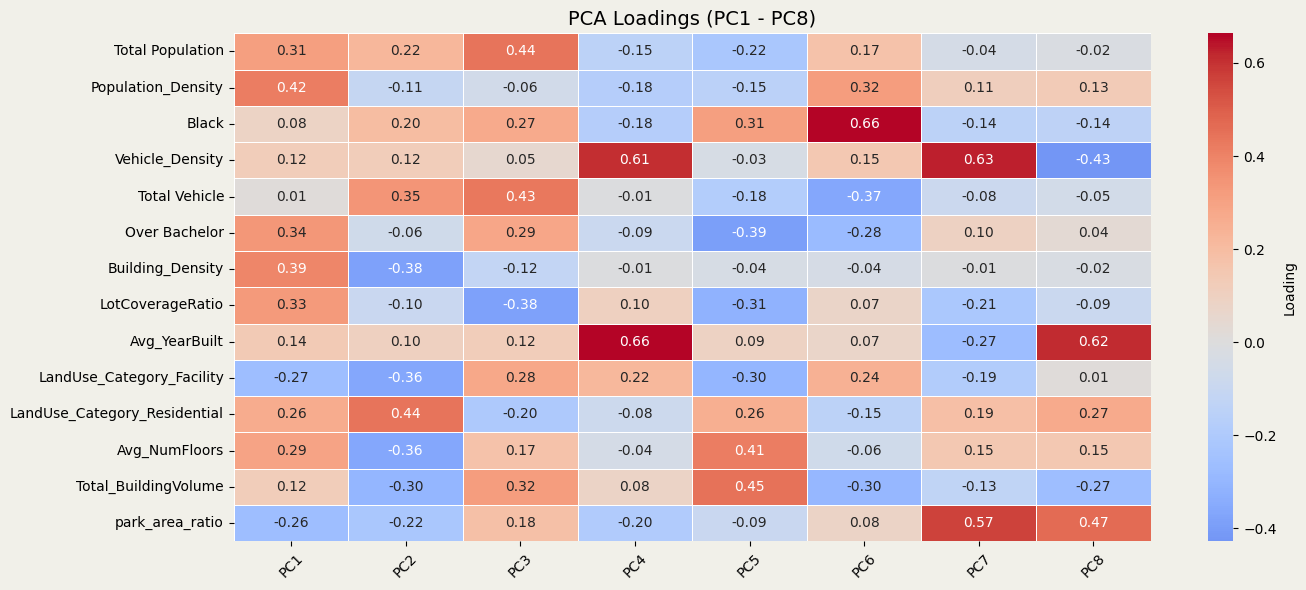

In [189]:
loadings = pd.DataFrame(pca.components_[:8], columns=X.columns, index=[f'PC{i+1}' for i in range(8)])

fig, ax = plt.subplots(figsize=(14, 6))
fig.patch.set_facecolor("#F1F0E9")
ax.set_facecolor("#F1F0E9")

sns.heatmap(loadings.T,annot=True,cmap='coolwarm',center=0,fmt=".2f",linewidths=0.5,cbar_kws={"label": "Loading"})
plt.title("PCA Loadings (PC1 - PC8)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [161]:
from sklearn.decomposition import PCA

# Retrieving the top 8 component to do the GWR
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_scaled)

# GWR Fitting
selector = Sel_BW(coords, y, X_pca)
opt_bw = selector.search()
print(f"Optimal bandwidth (PCA-GWR): {opt_bw}")
gwr_model = GWR(coords, y, X_pca, bw=opt_bw)
gwr_results = gwr_model.fit()

# Evaluate the Model
print("R²: ", gwr_results.R2)
print("Local coefficients shape:", gwr_results.params.shape) 

✅ Optimal bandwidth (PCA-GWR): 81.0
R²:  0.8817132837802005
Local coefficients shape: (6720, 9)


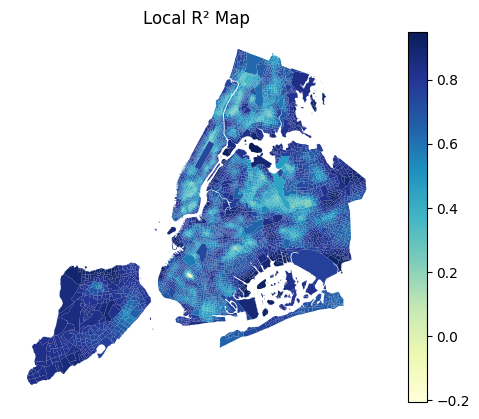

In [163]:
gdf["local_r2"] = gwr_results.localR2
gdf.plot(column="local_r2", cmap="YlGnBu", legend=True)
plt.title("Local R² Map")
plt.axis("off")
plt.show()

In [188]:
coefs = gwr_results.params[:, 1:]  # shape: (n_obs, 8)
# Evaluate the Contribution
mean_abs_contrib = np.mean(np.abs(coefs), axis=0)
pc_names = [f'PC{i+1}' for i in range(coefs.shape[1])]

contrib_df = pd.DataFrame({
    'PC_name': pc_names,
    'Mean | Coefficient': mean_abs_contrib
}).sort_values('Mean | Coefficient', ascending=False)

contrib_df

,PC_name,Mean | Coefficient
3,PC4,9.294453
6,PC7,8.086154
7,PC8,6.127410
1,PC2,2.194625
5,PC6,2.153809
0,PC1,1.907900
2,PC3,1.172023
4,PC5,1.112062
